# Notebook "3_Besoin_2_Exploration_Ineris"


## Description

Ce notebook se focalise sur l'analyse exploratoire des données INERIS. Cette analyse se décompose en deux grande partie :
- Etude de la volumétrie
- Etude de la volumétrie croisée

## Structure du notebook

Ce notebook est construit de plusieurs parties :
- I. Import des bibliothèques
- II. Préprocessing des données
- III. Analyse de la volumétrie
- IV. Analyse de la volumétrie croisée

## Prérequis

### Source de données

Pour que le notebook fonctionne, la base de données INERIS doit être disponible dans le même fichier que le notebook. Par ailleurs, cette source doit être au format csv avec le nom "DB_INERIS.csv"

### Installation des prérequis techniques

Le notebook fonctionne sur Python 3.7 avec les bibliothèques suivantes :
- pandas
- seaborn
- matplotlib
- numpy
- scipy

# I. Import des libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

# II. Préprocessing des données

## II.a Ajustement des données

In [2]:
substances = ['2378-TCDD', '12378-PeCDD', '123478-HxCDD', '123678-HxCDD',
       '123789-HxCDD', '1234678-HpCDD', 'OCDD', '2378-TCDF', '12378-PeCDF',
       '23478-PeCDF', '123478-HxCDF', '123678-HxCDF', '234678-HxCDF',
       '123789-HxCDF', '1234678-HpCDF', '1234789-HpCDF', 'OCDF']

substances_A = [sub + '_A' for sub in substances]
substances_C = [sub + '_C' for sub in substances]

total_homologue = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'OCDD', 
    'Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'OCDF']

total_dioxine = ['Total TCDD', 'Total PeCDD', 'Total HxCDD', 'Total HpCDD', 'Total DIOXINE']
total_furanne = ['Total TCDF', 'Total PeCDF', 'Total HxCDF', 'Total HpCDF', 'Total FURANE']

In [3]:
data = pd.read_csv('DB_INERIS.csv', sep=';')

data['Type de point de mesure'].replace({"source":"Source"}, inplace=True)
data = data.replace('-', np.nan)

# Mise au bot format des données Ineris
for col in (substances + total_homologue + ['Total DIOXINE', 'Total FURANE']):
    data[col] = data[col].astype(str)
    data[col] = [float(a.replace(',', '.')
                        .replace('94.759.846', "94759.846")
                        .replace('<', '')
                        .replace('ND', '0')
                        .replace('?', '.')
                        .replace(';', '.')
                        .replace('ç', '9')) for a in data[col].values]

In [4]:
columns_process = ['2378-TCDD', '<', '12378-PeCDD', '<.1', '123478-HxCDD',
       '<.2', '123678-HxCDD', '<.3', '123789-HxCDD', '<.4', '1234678-HpCDD',
       '<.5', 'OCDD', '<.6', '2378-TCDF', '<.7', '12378-PeCDF',
       '<.8', '23478-PeCDF', '<.9', '123478-HxCDF', '<.10', '123678-HxCDF',
       '<.11', '234678-HxCDF', '<.12', '123789-HxCDF', '<.13', '1234678-HpCDF',
       '<.14', '1234789-HpCDF', '<.15', 'OCDF', '<.16',
       'Total TCDD', '<.17', 'Total PeCDD', '<.18', 'Total HxCDD', '<.19',
       'Total HpCDD', '<.20', 'Total DIOXINE', '<.21', 'Total TCDF', '<.22',
       'Total PeCDF', '<.23', 'Total HxCDF', '<.24', 'Total HpCDF', '<.25',
       'Total FURANE', '<.26']

for col in columns_process:
    if '<' in col:
        coef = []
        for a in data[col].values:
            if(a == '<' or a == 'ND' or a == 0 or a == '0'):
                coef.append(0)
            else:
                coef.append(1)
        data[old_col] = data[old_col] * coef
    else:
        old_col = col


## II.b Normalisation A

In [5]:
table_final = data.copy()
table_final["total sub 2378"] = 0
for sub in substances:
    table_final["total sub 2378"] += table_final[sub]

In [6]:
table_norme_A = table_final.copy()
for sub in substances:
    table_norme_A[sub + '_A'] = table_norme_A[sub]  / table_final["total sub 2378"]

## II.c Normalisation C

In [7]:
# Choix de la normalisation des congénère OCDD et OCDF
# Valeur True => Normalisation par la concentration total
# Valeur False => Normalisation avec la définition classique
normalisation_C_disc = True

In [8]:
table_norme_C = table_final.copy()

for col in total_homologue:
    table_final["total homologue"] = 0
    table_final["total homologue"] += table_final[col]
table_norme_C = table_final[table_final["total homologue"] > 0]

substance_in = {}
for homologue in total_homologue:
    if(homologue != "OCDD" and homologue != "OCDF"):
        list_sub = []
        text_ref_homologue = homologue.replace("Total ", "")
        table_norme_C[text_ref_homologue] = 0
        for sub in substances:
            if sub.find(text_ref_homologue) != -1:
                list_sub.append(sub)
                table_norme_C[text_ref_homologue] += table_norme_C[sub]
        substance_in[homologue] = list_sub
        text_ref_homologue_2 = text_ref_homologue + "_2"
        table_norme_C[text_ref_homologue_2] = table_norme_C[text_ref_homologue] * 0.9
        table_norme_C = table_norme_C[table_norme_C[text_ref_homologue_2] <= table_norme_C[homologue]]
    else:
        substance_in[homologue] = [homologue]

In [9]:
table_norme_C['TOTAL PCDD'] = table_norme_C['TCDD'] + table_norme_C['PeCDD'] + table_norme_C['HxCDD'] + table_norme_C['HpCDD'] + table_norme_C['OCDD']
table_norme_C['TOTAL PCDF'] = table_norme_C['TCDF'] + table_norme_C['PeCDF'] + table_norme_C['HxCDF'] + table_norme_C['HpCDF'] + table_norme_C['OCDF'] 

for homologue in total_homologue:
    for sub in substance_in[homologue]:
        if sub == 'OCDD':
            if(normalisation_C_disc):
                table_norme_C['OCDD'] = table_norme_C['OCDD'] / table_norme_C['TOTAL PCDD']
            else:
                table_norme_C[sub] = 1
        elif sub == 'OCDF':
            if(normalisation_C_disc):
                table_norme_C['OCDF'] = table_norme_C['OCDF'] / table_norme_C['TOTAL PCDF']
            else:
                table_norme_C[sub] = 1
        else:
            table_norme_C[sub] = table_norme_C[sub] / table_norme_C[homologue]
table_norme_C = table_norme_C.fillna(0)
table_norme_C = table_norme_C.replace(np.inf, 0)
renaming = { pre : nex for (pre, nex) in zip(substances, substances_C) }
table_norme_C = table_norme_C.rename(columns = renaming)

# III. Analyse volumétrie

## III.a Nombre d'échantillons

In [10]:
data_A = table_norme_A[table_norme_A["Fournisseur"] != "US EPA"]
print("Nombre d'échantillons Ineris (hors EPA) : ", len(data_A))

Nombre d'échantillons Ineris (hors EPA) :  820


In [11]:
data_C = table_norme_C[table_norme_C["Fournisseur"] != "US EPA"]
print("Nombre d'échantillons pour la normalisation C : ", len(data_C), "\nTaux restant : ", round(len(data_C) * 100 / len(data_A), 3), "%")

Nombre d'échantillons pour la normalisation C :  262 
Taux restant :  31.951 %


## III.b Analyse des données manquantes
Variable et pourcentage de données manquantes

In [12]:
data_miss = pd.isna(data_A).replace(False, 0).replace(True, 1)
np.mean(pd.isna(data_A).replace(False, 0).replace(True, 1)) * 100

Fournisseur                             25.121951
Nom du projet                            0.609756
Catégorie de l'activité industrielle     0.609756
Sous-catégorie                           0.609756
Réf. échantillon                         0.365854
                                          ...    
234678-HxCDF_A                           6.463415
123789-HxCDF_A                           6.463415
1234678-HpCDF_A                          6.463415
1234789-HpCDF_A                          6.463415
OCDF_A                                   6.463415
Length: 110, dtype: float64

## III.c Fournisseurs

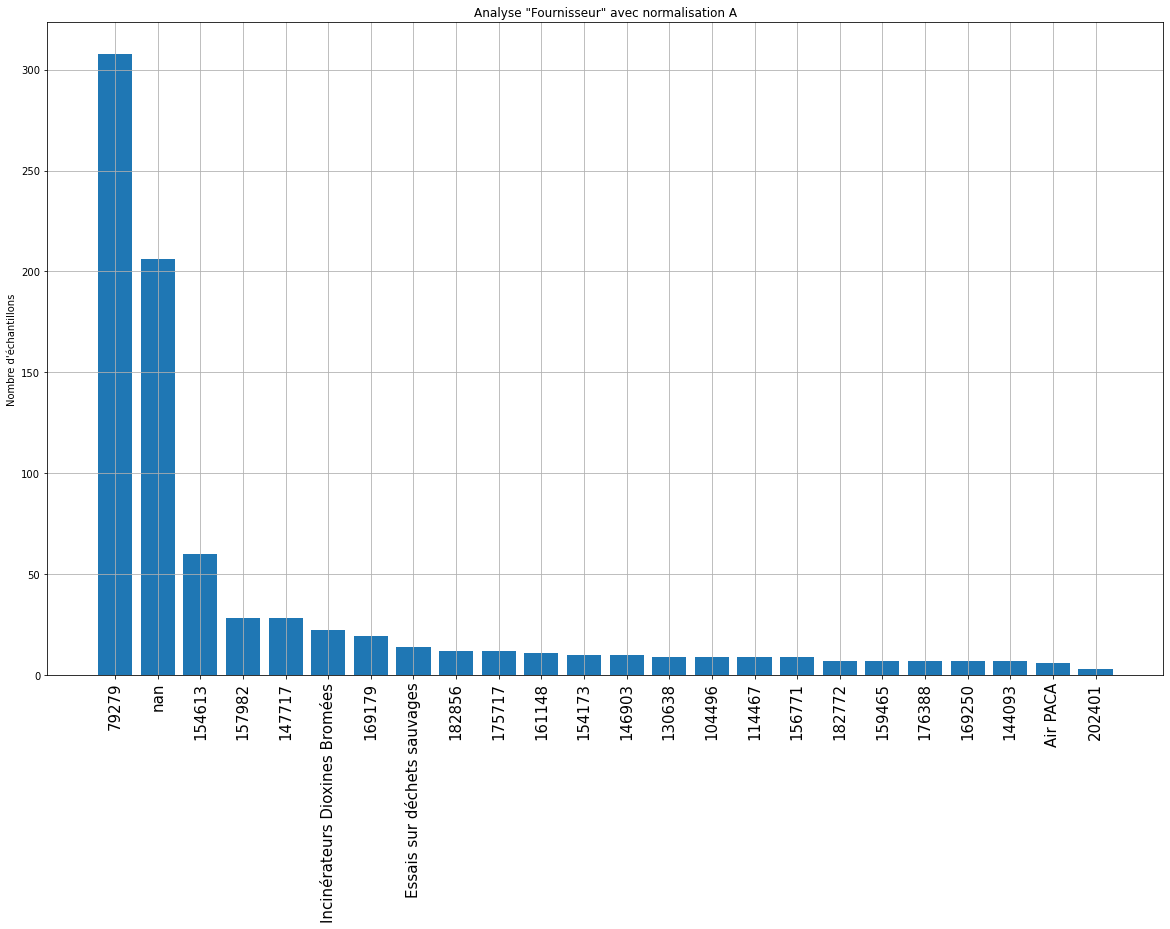

In [13]:
col = "Fournisseur"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

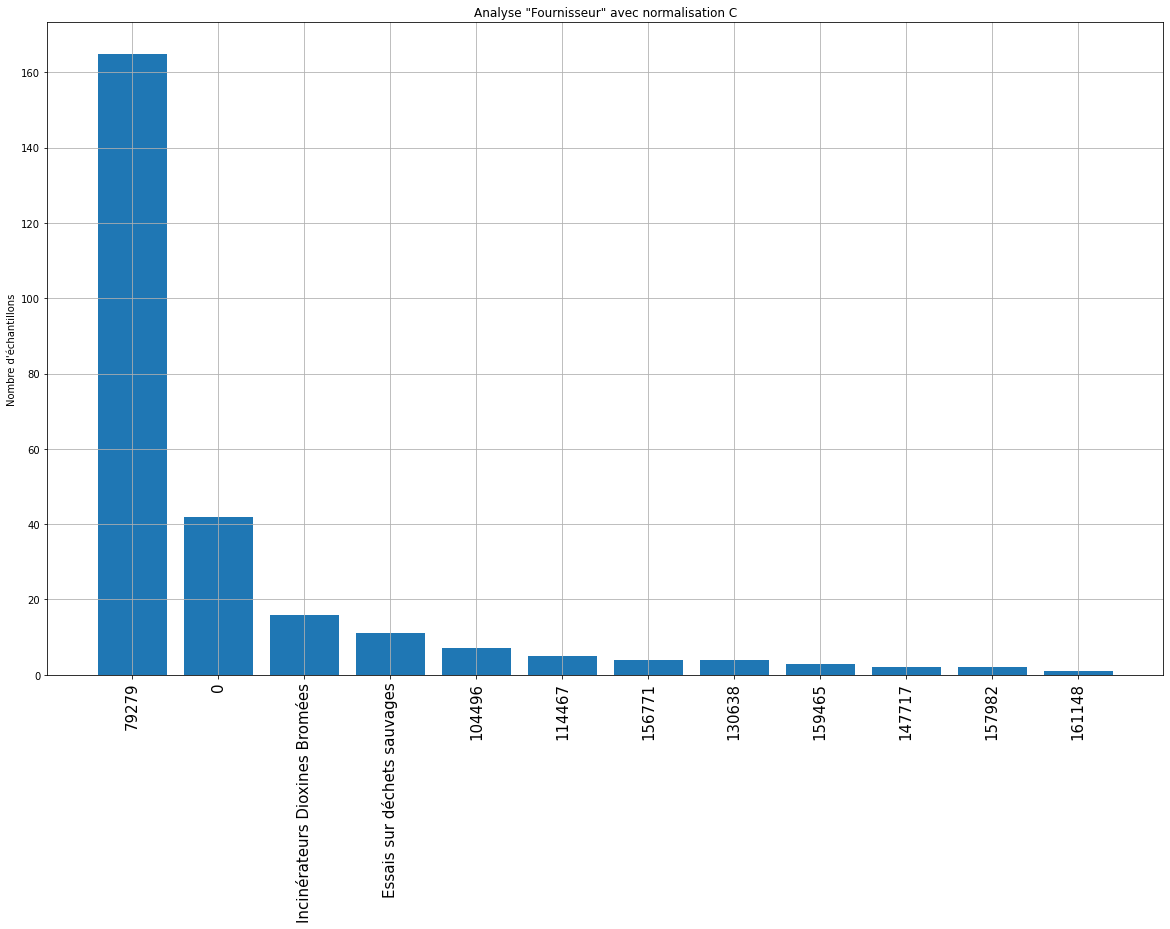

In [14]:
col = "Fournisseur"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## III.d Nom du projet

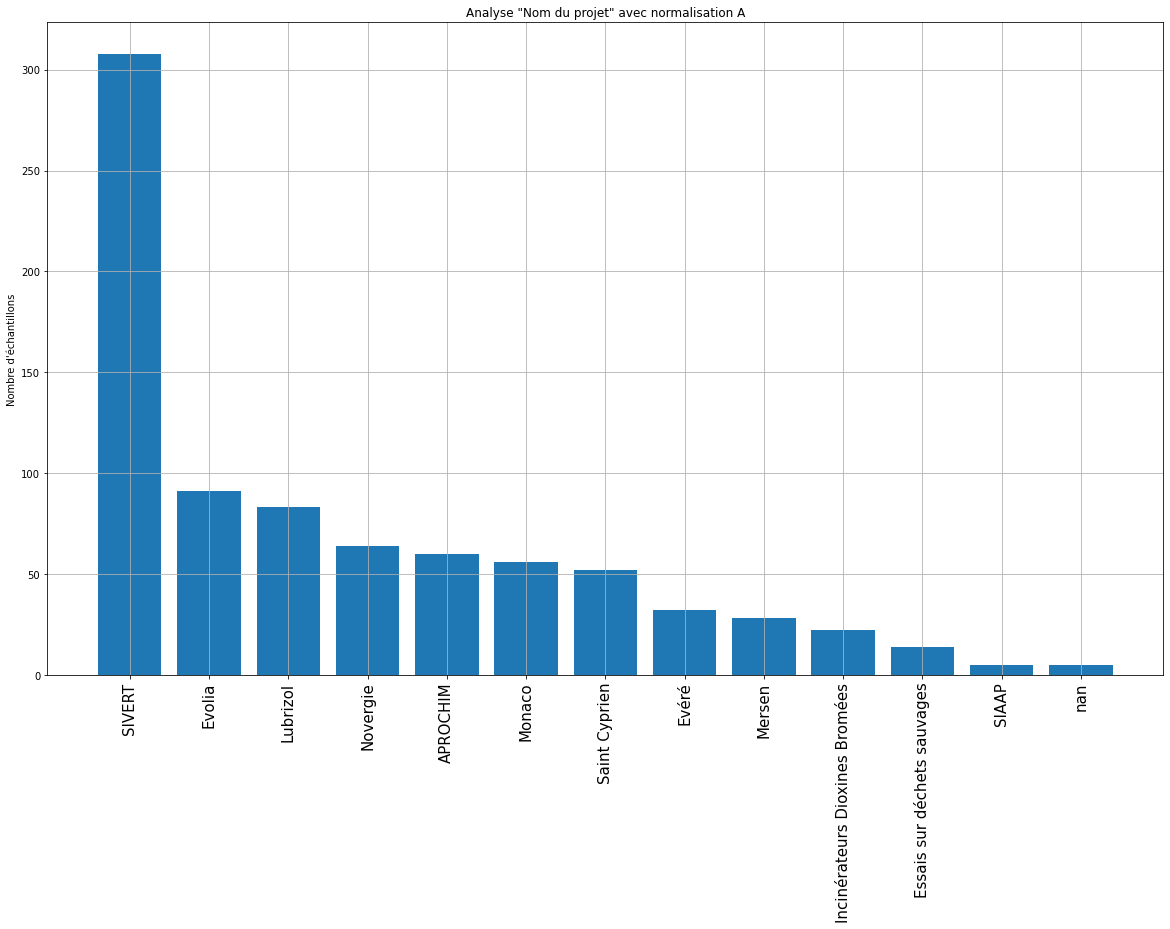

In [15]:
col = "Nom du projet"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

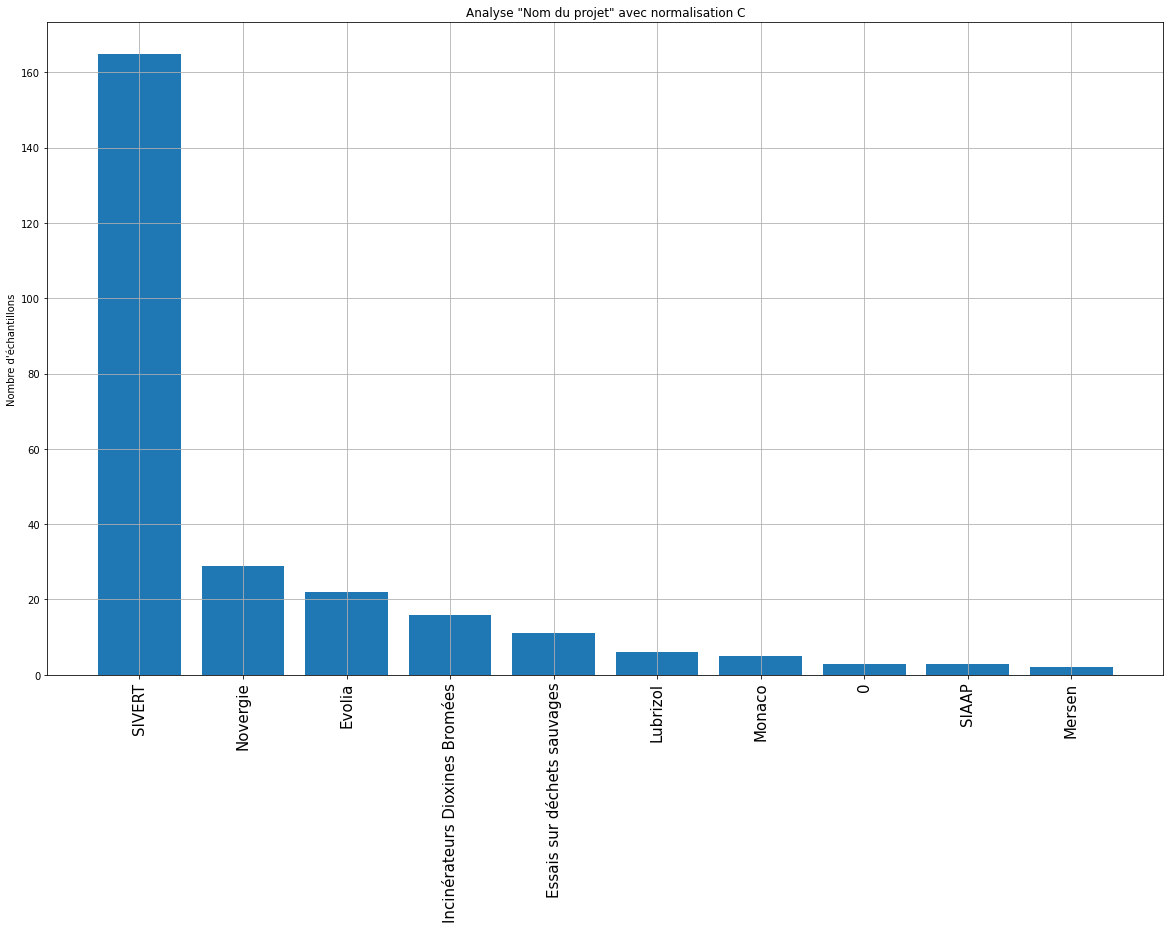

In [16]:
col = "Nom du projet"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## III.e Source

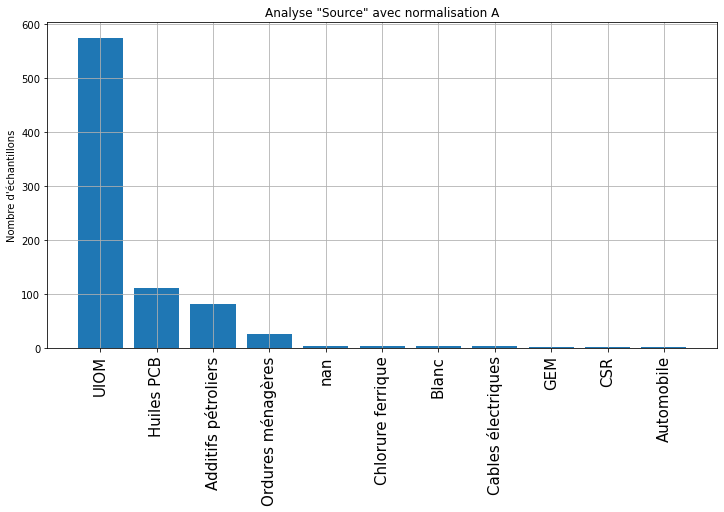

In [17]:
col = "Source"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

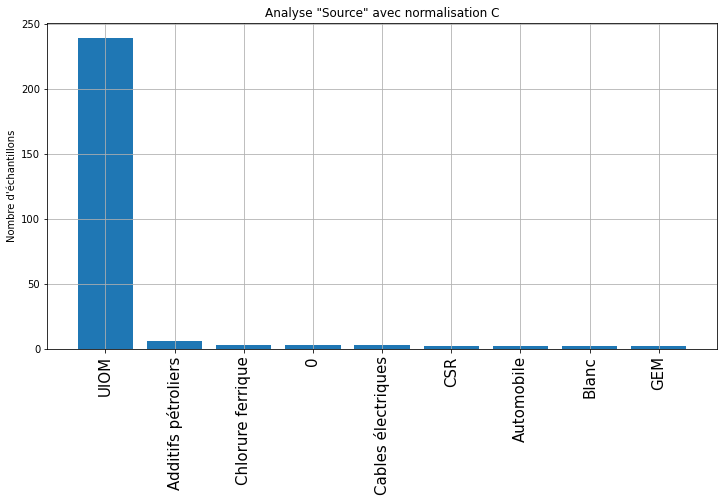

In [18]:
col = "Source"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## III.f Matrice

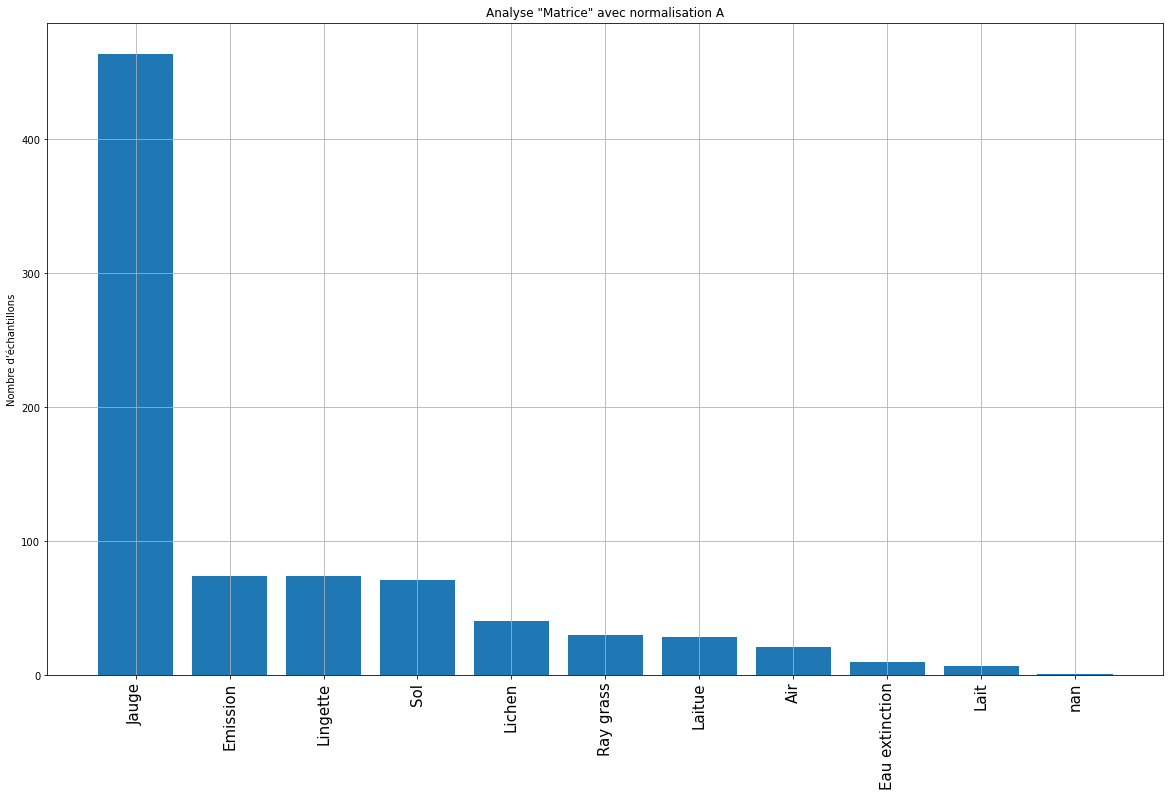

In [19]:
col = "Matrice"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(20, 12))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

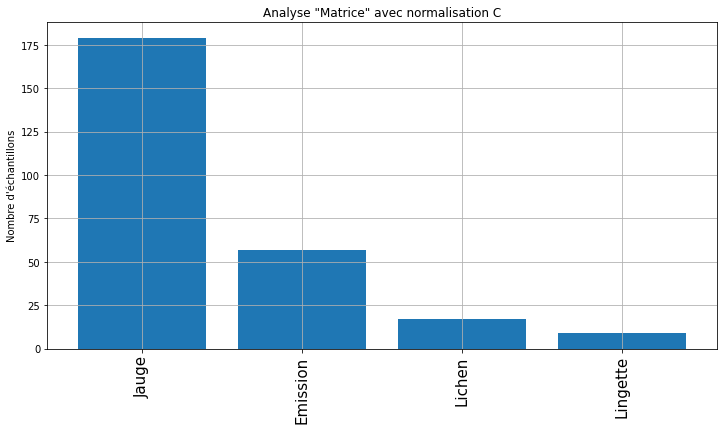

In [20]:
col = "Matrice"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.ylabel("Nombre d'échantillons")
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.grid()
plt.show()

## III.g Contexte

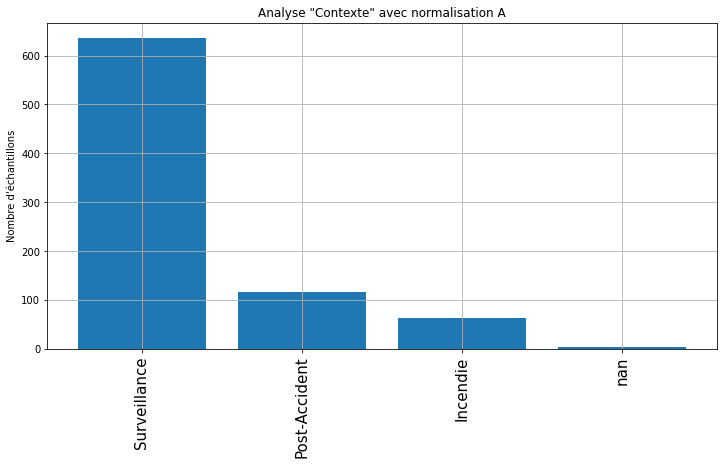

In [21]:
col = "Contexte"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

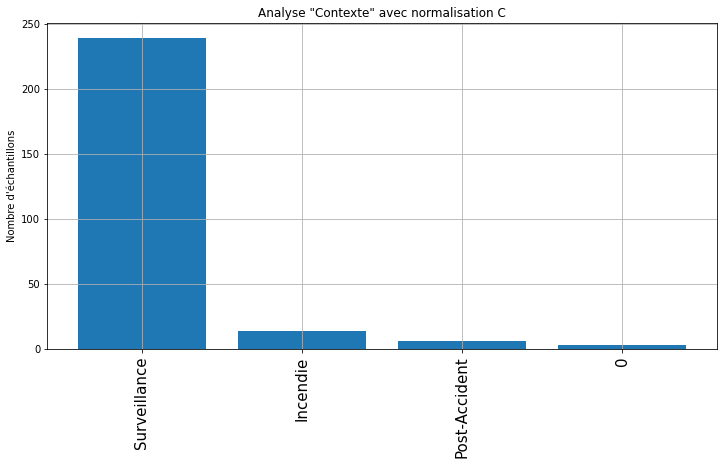

In [22]:
col = "Contexte"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## III.h Type de point de mesure

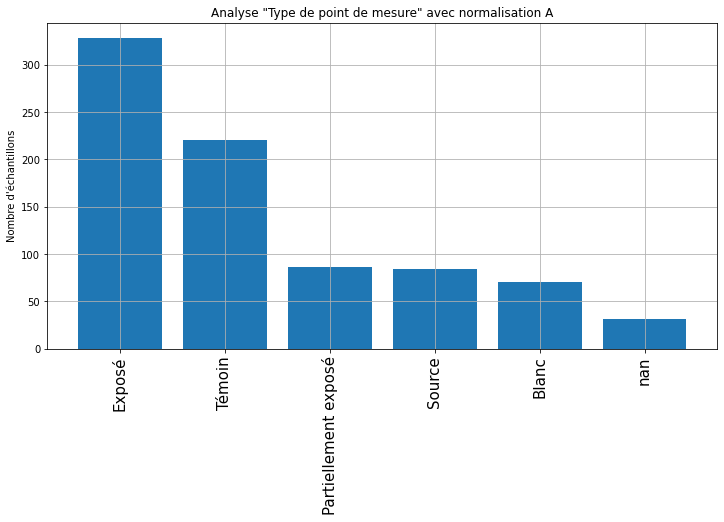

In [23]:
col = "Type de point de mesure"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

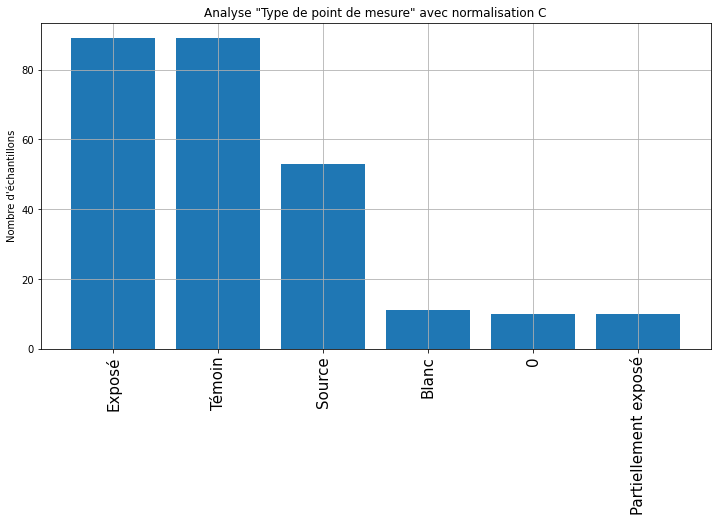

In [24]:
col = "Type de point de mesure"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## III.i Catégorie

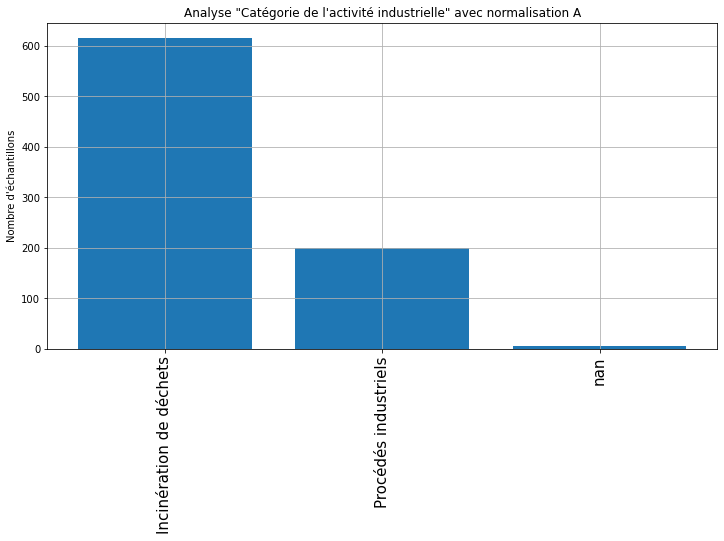

In [25]:
col = "Catégorie de l'activité industrielle"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

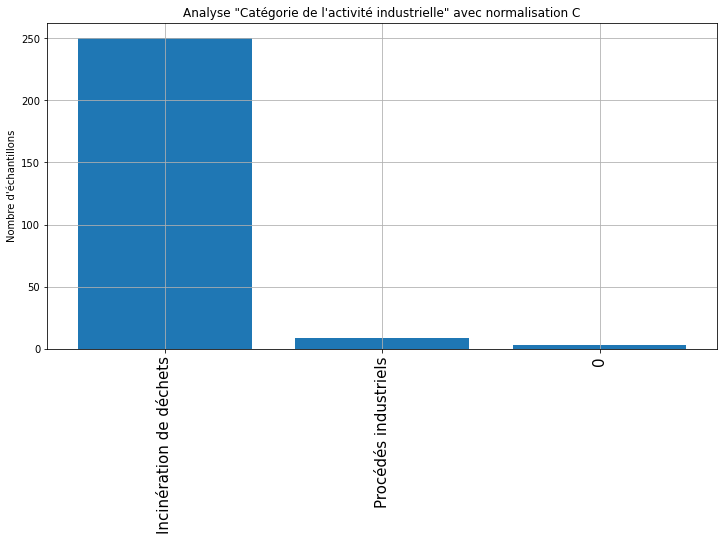

In [26]:
col = "Catégorie de l'activité industrielle"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

## III.j Sous catégorie

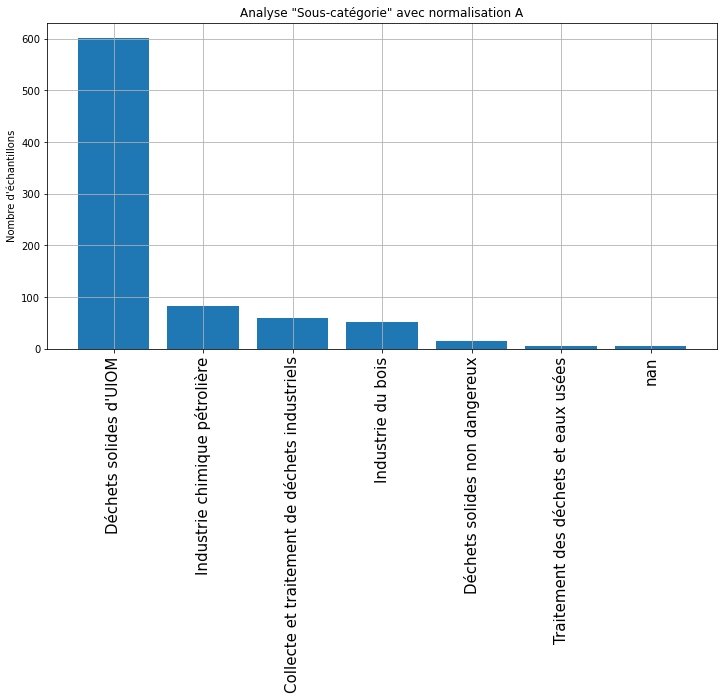

In [27]:
col = "Sous-catégorie"
data_A[col] = data_A[col].astype(str)
data_A[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_A[col].value_counts().index, data_A[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation A")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

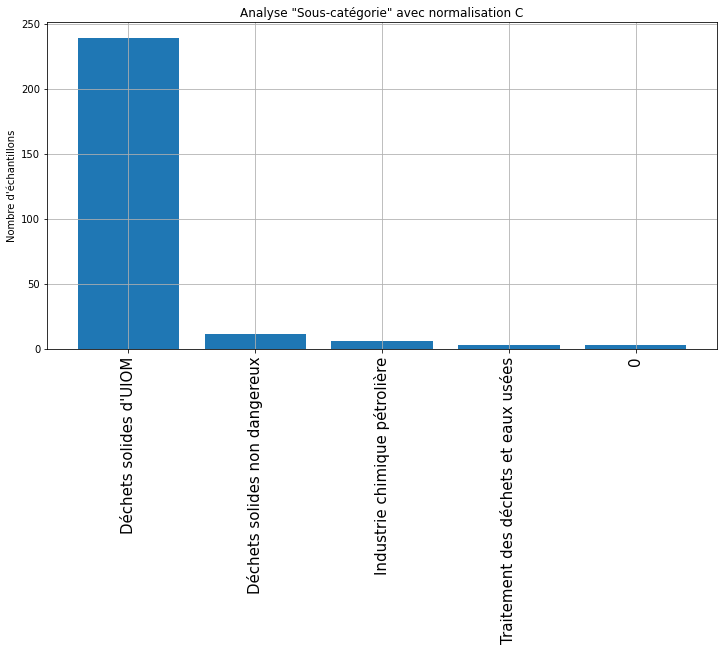

In [28]:
col = "Sous-catégorie"
data_C[col] = data_C[col].astype(str)
data_C[col].value_counts()
plt.figure(figsize=(12, 6))
plt.bar(data_C[col].value_counts().index, data_C[col].value_counts().values)
plt.xticks(fontsize=15,rotation=90)
plt.title("Analyse \"" + col + "\" avec normalisation C")
plt.ylabel("Nombre d'échantillons")
plt.grid()
plt.show()

# IV. Analyse de volumétrie croisée

## IV.a Analyse brute (Tableau de contingence)

### Matrice x Fournisseur

In [29]:
cols = ["Type de point de mesure", "Nom du projet"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Nom du projet,APROCHIM,Essais sur déchets sauvages,Evolia,Evéré,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT,Saint Cyprien,nan
Type de point de mesure,,,,,,,,,,,,,
Blanc,0,4,6,0,0,10,4,8,7,1,31,0,0
Exposé,47,0,41,12,0,33,10,32,38,0,92,23,0
Partiellement exposé,8,0,9,8,0,27,6,0,6,1,8,13,0
Source,0,10,3,1,22,12,0,0,0,2,31,3,0
Témoin,5,0,32,11,0,1,8,16,13,1,120,13,0
nan,0,0,0,0,0,0,0,0,0,0,26,0,5


In [30]:
cols = ["Type de point de mesure", "Nom du projet"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Nom du projet,0,Essais sur déchets sauvages,Evolia,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT
Type de point de mesure,,,,,,,,,,
0,3,0,0,0,0,0,0,0,0,7
Blanc,0,2,0,0,1,0,1,0,1,6
Exposé,0,0,13,0,3,2,1,20,0,50
Partiellement exposé,0,0,3,0,2,0,0,5,0,0
Source,0,9,0,16,0,0,0,0,1,27
Témoin,0,0,6,0,0,0,3,4,1,75


### Matrice x Type de point de mesure

In [31]:
cols = ["Matrice", "Type de point de mesure"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]]) 

Type de point de mesure,Blanc,Exposé,Partiellement exposé,Source,Témoin,nan
Matrice,,,,,,
Air,6,5,8,0,2,0
Eau extinction,0,0,0,10,0,0
Emission,4,0,0,66,0,4
Jauge,46,225,28,0,165,0
Lait,0,7,0,0,0,0
Laitue,1,13,0,0,14,0
Lichen,0,6,1,0,7,26
Lingette,9,30,28,5,2,0
Ray grass,5,10,0,0,15,0


In [32]:
cols = ["Matrice", "Type de point de mesure"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Type de point de mesure,0,Blanc,Exposé,Partiellement exposé,Source,Témoin
Matrice,,,,,,
Emission,3,2,0,0,52,0
Jauge,0,7,82,8,0,82
Lichen,7,0,4,0,0,6
Lingette,0,2,3,2,1,1


### Matrice x Contexte

In [33]:
cols = ["Matrice", "Contexte"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Contexte,Incendie,Post-Accident,Surveillance,nan
Matrice,,,,
Air,0,9,12,0
Eau extinction,10,0,0,0
Emission,14,0,56,4
Jauge,3,3,458,0
Lait,0,0,7,0
Laitue,0,0,28,0
Lichen,4,0,36,0
Lingette,14,60,0,0
Ray grass,0,0,30,0


In [34]:
cols = ["Matrice", "Contexte"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Contexte,0,Incendie,Post-Accident,Surveillance
Matrice,,,,
Emission,3,11,0,43
Jauge,0,0,0,179
Lichen,0,0,0,17
Lingette,0,3,6,0


### Matrice x Nom du projet

In [35]:
cols = ["Matrice", "Nom du projet"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Nom du projet,APROCHIM,Essais sur déchets sauvages,Evolia,Evéré,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT,Saint Cyprien,nan
Matrice,,,,,,,,,,,,,
Air,0,0,0,0,0,5,0,0,0,0,12,4,0
Eau extinction,0,0,0,1,0,9,0,0,0,0,0,0,0
Emission,0,14,3,0,22,0,0,0,0,0,31,0,4
Jauge,60,0,75,9,0,0,28,56,62,0,171,3,0
Lait,0,0,5,0,0,0,0,0,2,0,0,0,0
Laitue,0,0,0,0,0,0,0,0,0,0,28,0,0
Lichen,0,0,0,4,0,0,0,0,0,0,36,0,0
Lingette,0,0,0,0,0,69,0,0,0,5,0,0,0
Ray grass,0,0,0,0,0,0,0,0,0,0,30,0,0


In [36]:
cols = ["Matrice", "Nom du projet"]
pd.crosstab(data_C[cols[0]], data_C[cols[1]])

Nom du projet,0,Essais sur déchets sauvages,Evolia,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT
Matrice,,,,,,,,,,
Emission,3,11,0,16,0,0,0,0,0,27
Jauge,0,0,22,0,0,2,5,29,0,121
Lichen,0,0,0,0,0,0,0,0,0,17
Lingette,0,0,0,0,6,0,0,0,3,0


### Source x Nom du projet

In [37]:
cols = ["Source", "Nom du projet"]
pd.crosstab(data_A[cols[0]], data_A[cols[1]])

Nom du projet,APROCHIM,Essais sur déchets sauvages,Evolia,Evéré,Incinérateurs Dioxines Bromées,Lubrizol,Mersen,Monaco,Novergie,SIAAP,SIVERT,Saint Cyprien,nan
Source,,,,,,,,,,,,,
Additifs pétroliers,0,0,0,0,0,83,0,0,0,0,0,0,0
Automobile,0,2,0,0,0,0,0,0,0,0,0,0,0
Blanc,0,4,0,0,0,0,0,0,0,0,0,0,0
CSR,0,2,0,0,0,0,0,0,0,0,0,0,0
Cables électriques,0,4,0,0,0,0,0,0,0,0,0,0,0
Chlorure ferrique,0,0,0,0,0,0,0,0,0,5,0,0,0
GEM,0,2,0,0,0,0,0,0,0,0,0,0,0
Huiles PCB,60,0,0,0,0,0,0,0,0,0,0,52,0
Ordures ménagères,0,0,0,26,0,0,0,0,0,0,0,0,0


## IV.b Analyse de la contribution de l'indépendance des variables catégorielle

Haute valeur indique une dépendance pour ces valeurs

In [38]:
def chi2_test(contingency_df: pd.DataFrame, verbose: bool=True):
    """
    Perform a chi square independance test between two categorical variables
    
    contingency_df: DataFrame of contingency matrix between two categorical variables
    verbose: verbose
    """
    
    st_chi2, st_p, st_dof, st_exp = chi2_contingency(contingency_df)
    
    if verbose:
        print(f"test statistic: {st_chi2}")
        print(f"test p-value: {st_p}")
        print(f"degree of freedom: {st_dof}")
    
    return st_chi2, st_p, st_dof

def chi2_non_independance_contrib_plot(contingency_df: pd.DataFrame, len_data: int, figsize:tuple=(12, 10)):
    """a
    Plot heatmap of non independance contribution of categorical variables elements.
    High value indicates strong contribution to non independance.
    
    contingency_df: DataFrame of contingency matrix between two categorical variables
    len_data: length of the dataset
    
    https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4775616-analysez-deux-variables-qualitatives-avec-le-chi-2
    """
    
    fig = plt.figure(figsize=figsize)
    tx = pd.DataFrame(contingency_df.sum(axis=1))
    ty = pd.DataFrame(contingency_df.sum(axis=0)).T
    n = len_data
    indep = tx.dot(ty) / n

    c = contingency_df.fillna(0) 
    measure = (c-indep)**2/indep
    xi_n = measure.sum().sum()
    table = measure/xi_n
    sns.heatmap(table, annot=table, cmap='RdPu', ax=fig.gca())
    #plt.tight_layout()
    plt.show()

### Matrice x Type de point de mesure

test statistic: 1314.6890794073838
test p-value: 2.3407152893582837e-242
degree of freedom: 50


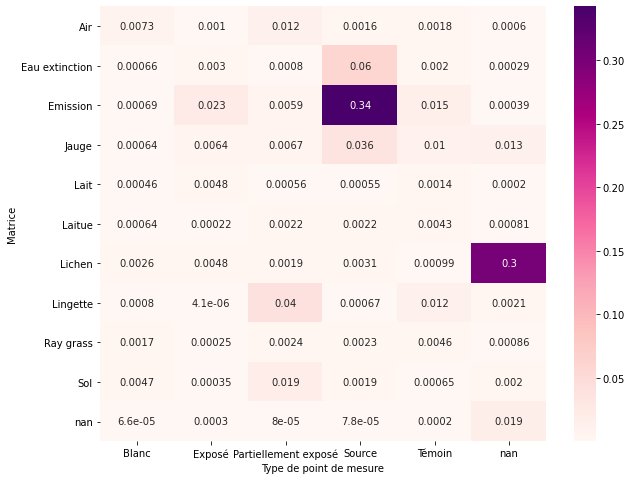

In [39]:
cols = ["Matrice", "Type de point de mesure"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))

### Matrice x Nom du projet

test statistic: 2137.368482461457
test p-value: 0.0
degree of freedom: 120


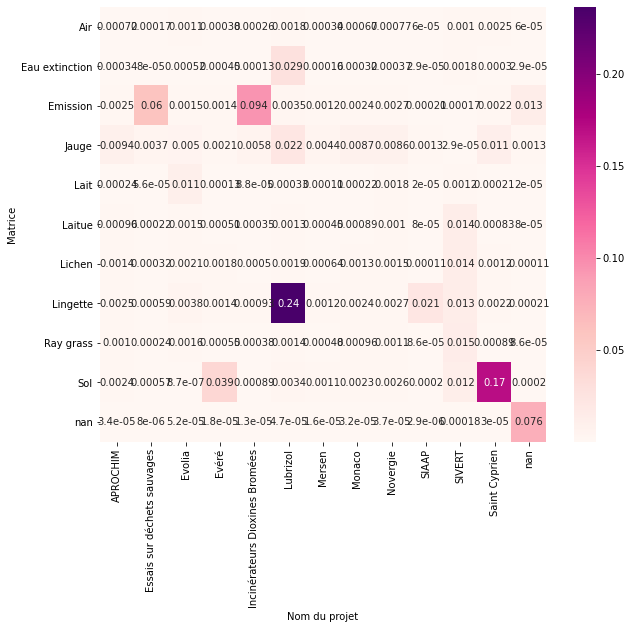

In [40]:
cols = ["Matrice", "Nom du projet"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))

### Type de point de mesure x Nom du projet

test statistic: 653.2233582587337
test p-value: 1.4287999130425092e-100
degree of freedom: 60


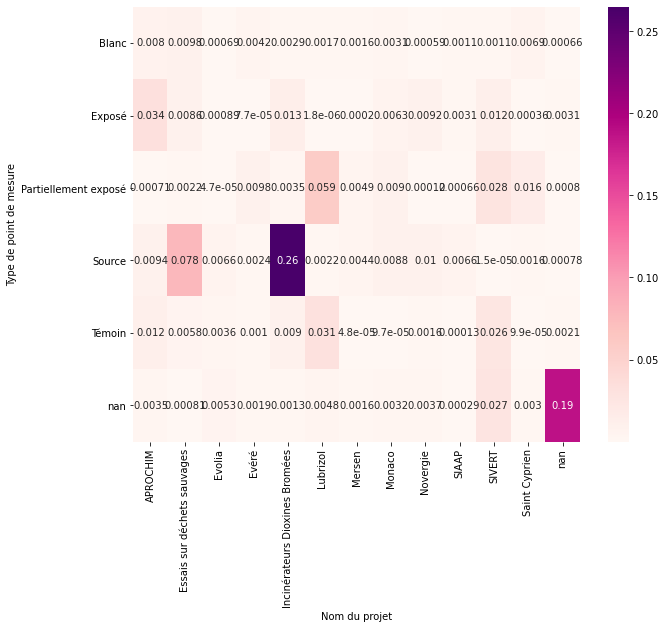

In [41]:
cols = ["Type de point de mesure", "Nom du projet"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))

test statistic: 352.55620422153737
test p-value: 9.671022545414e-57
degree of freedom: 30


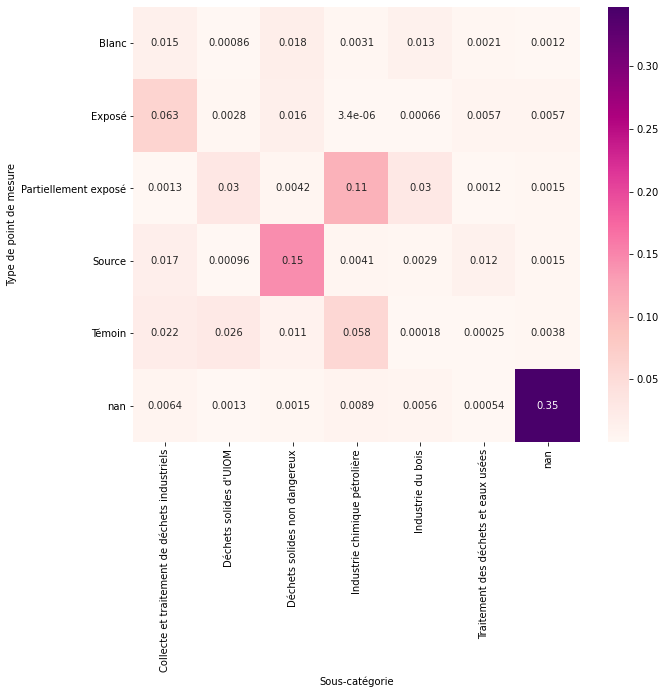

In [43]:
cols = ["Type de point de mesure", "Sous-catégorie"]

domain_measure_cross_df = pd.crosstab(data_A[cols[0]], data_A[cols[1]], margins=True)
_ = chi2_test(domain_measure_cross_df.iloc[:-1, :-1], verbose=True)
chi2_non_independance_contrib_plot(domain_measure_cross_df.iloc[:-1, :-1], len(data_A), figsize=(10, 8))